In [2]:
#Plots
import pickle
import healpy as hp
import matplotlib
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 2})
import matplotlib.pyplot as plt
import os
os.environ['DISABLE_MPI']="true"
from os.path import join as opj
import numpy as np
from solenspipe import weighted_bin1D
from collections import OrderedDict
from pixell import curvedsky

Read in kSZ and foreground Cls 

In [3]:
#Read in ksz Cls for 10muK
cls_ksz = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/no_fgs/recon_0/cmb_1999/cl_0093_rr.npy')
#And for 5muK
cls_ksz_2muK = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/no_fgs/recon_2muK/cmb_1999/cl_0093_rr.npy')
cls_ksz_20muK = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/no_fgs/recon_20muK/cmb_1999/cl_0093_rr.npy')
print(cls_ksz.dtype.names)

('sky', 'sky_N0_normed', 'sky_N0_nonorm', 'sky_lh', 'sky_psh', 'cmb', 'cmb_N0_normed', 'cmb_N0_nonorm', 'cmb_lh', 'cmb_psh', 'kszr', 'kszr_N0_normed', 'kszr_N0_nonorm', 'kszr_lh', 'kszr_N0_lh_normed', 'kszr_N0_lh_nonorm', 'kszr_psh', 'N0_K_normed', 'N0_K_nonorm', 'N0_K_lh_normed', 'N0_K_lh_nonorm', 'N0_K_psh_normed', 'N0_K_psh_nonorm')


In [5]:
#And some fg terms (for the lensing)
cls_fg = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/tsz_only_14.8/fg_terms_0/fg_terms_0093.npy')
print(cls_fg.dtype.names)

('cl_KphiKphi', 'trispectrum_qe', 'trispectrum_N0_qe', 'trispectrum_psh', 'trispectrum_N0_psh', 'trispectrum_lh', 'trispectrum_N0_lh', 'trispectrum_masked_qe', 'trispectrum_N0_masked_qe', 'trispectrum_masked_psh', 'trispectrum_N0_masked_psh', 'trispectrum_masked_lh', 'trispectrum_N0_masked_lh', 'trispectrum_modelsub_qe', 'trispectrum_N0_modelsub_qe', 'trispectrum_modelsub_psh', 'trispectrum_N0_modelsub_psh', 'trispectrum_modelsub_lh', 'trispectrum_N0_modelsub_lh')


Do some binning in l

In [7]:
from solenspipe import weighted_bin1D
lmin_K=10
lmax_K=300
nbin=20
def bin_cl(cl, lmin=lmin_K, lmax=lmax_K, nbin=nbin):
    ells = np.arange(len(cl))
    bin_edges = np.linspace(lmin,lmax+1,nbin).astype(int)
    nbin = len(bin_edges)-1
    cl_binned = np.zeros(nbin)
    for i,(lo,hi) in enumerate(zip(bin_edges[:-1],bin_edges[1:])):
        use = (ells>=lo)*(ells<hi)
        weights = ells[use]*(ells[use]+1)
        cl_binned[i] = np.average(cl[use], weights=ells[use]*(ells[use]+1))
    ell_mids = 0.5*(bin_edges[:-1]+bin_edges[1:])
    return ell_mids, cl_binned

In [8]:
#10muK
ell_mids, cl_ksz_raw = bin_cl(cls_ksz['kszr'])
_, cl_ksz_N0 = bin_cl(cls_ksz['kszr_N0_normed'])
cl_ksz = cl_ksz_raw-cl_ksz_N0

#2muK
_, cl_ksz_2muK_raw = bin_cl(cls_ksz_2muK['kszr'])
_, cl_ksz_2muK_N0 = bin_cl(cls_ksz_2muK['kszr_N0_normed'])
cl_ksz_2muK = cl_ksz_2muK_raw-cl_ksz_2muK_N0

#2muK
_, cl_ksz_20muK_raw = bin_cl(cls_ksz_20muK['kszr'])
_, cl_ksz_20muK_N0 = bin_cl(cls_ksz_20muK['kszr_N0_normed'])
cl_ksz_20muK = cl_ksz_2muK_raw-cl_ksz_20muK_N0

#N0s
_, total_N0 = bin_cl(cls_ksz['N0_K_normed'])
_, total_N0_lh = bin_cl(cls_ksz['N0_K_lh_normed'])
_, total_N0_psh = bin_cl(cls_ksz['N0_K_psh_normed'])
_, total_N0_2muK = bin_cl(cls_ksz_2muK['N0_K_normed'])
_, total_N0_20muK = bin_cl(cls_ksz_20muK['N0_K_normed'])

#lensing
_, cl_lens = bin_cl(cls_fg['cl_KphiKphi'])

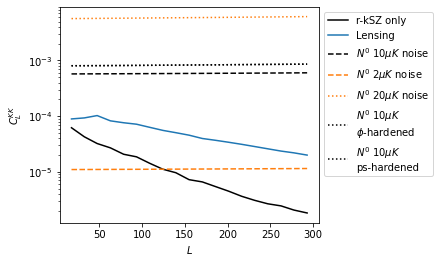

In [25]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])


#llp1 = ell_mids*(ell_mids+1)
llp1 = np.ones_like(ell_mids)
ax.plot(ell_mids, llp1*cl_ksz, 'k', label=r'r-kSZ only')
#ax.plot(ell_mids, llp1*cl_ksz_2muK, 'C1', label=r'r-kSZ only 2muK')
ax.plot(ell_mids, llp1*cl_lens, 'C0', label="Lensing")
#ax.plot(ell_mids, cl_ksz_N0, 'k--')
#ax.plot(ell_mids, cl_lens, 'C0')
ax.plot(ell_mids, llp1*total_N0, 'k--', label=r'$N^0$ 10$\mu K$ noise')
ax.plot(ell_mids, llp1*total_N0_2muK, 'C1', linestyle='--', label=r'$N^0$ 2$\mu K$ noise')
ax.plot(ell_mids, llp1*total_N0_20muK, 'C1', linestyle=':', label=r'$N^0$ 20$\mu K$ noise')
ax.plot(ell_mids, llp1*total_N0_lh, 'k', linestyle=':', label=r'$N^0$ 10$\mu K$'+'\n'+'$\phi$-hardened')
ax.plot(ell_mids, llp1*total_N0_lh, 'k', linestyle=':', label=r'$N^0$ 10$\mu K$'+'\n'+'ps-hardened')
if np.allclose(llp1,1.):
    ax.set_ylabel(r"$C_L^{KK}$")
else:
    ax.set_ylabel(r"$C_L^{KK}$")
ax.set_yscale('log')
ax.set_xlabel(r'$L$')
lg=ax.legend(ncol=1,bbox_to_anchor=(1., 1.), loc='upper left')
filename = "ksz_lensing_noise.png"
fig.savefig(filename,dpi=300,bbox_extra_artists=[lg],bbox_inches='tight')

## S/N estimates

Get some signal-to-noise estimates. 

$(S/N)^2 = f_{\mathrm{sky}} \sum_L (2L+1) \frac{(C_L^{KK})^2}{2(C_L^{KK} + N^0_L)^2}$

In [30]:
def get_snr(cl_KK, N0, lmax, fsky):
    Ls = np.arange(1,lmax+1)
    snr2 = fsky * np.sum(
        (2*Ls+1) * (cl_KK[1:lmax+1]**2) / 2 / (cl_KK[1:lmax+1]+N0[1:lmax+1])**2
    )
    return np.sqrt(snr2)

In [31]:
lmax=300
fsky=15./40

#10muK qe
cl_KK = cls_ksz['kszr'] - cls_ksz['kszr_N0_normed']
snr_qe_10muk = get_snr(cl_KK, cls_ksz["N0_K_normed"], 300, fsky)
snr_lh_10muK = get_snr(cl_KK, cls_ksz["N0_K_lh_normed"], 300, fsky)
snr_psh_10muK = get_snr(cl_KK, cls_ksz["N0_K_psh_normed"], 300, fsky)
snr_qe_2muk = get_snr(cl_KK, cls_ksz_2muK["N0_K_normed"], 300, fsky)
snr_lh_2muK = get_snr(cl_KK, cls_ksz_2muK["N0_K_lh_normed"], 300, fsky)
snr_psh_2muK = get_snr(cl_KK, cls_ksz_2muK["N0_K_psh_normed"], 300, fsky)

Make a table

|             | 2$\mu$K |
| ----------- | ----------- |
| QE      | Title       |
| Lensing-hardened   | Text        |
| Point source-hardened   | Text        |

In [6]:
print(cls_ksz.dtype.names)

('sky', 'sky_N0_normed', 'sky_N0_nonorm', 'sky_lh', 'sky_psh', 'cmb', 'cmb_N0_normed', 'cmb_N0_nonorm', 'cmb_lh', 'cmb_psh', 'kszr', 'kszr_N0_normed', 'kszr_N0_nonorm', 'kszr_lh', 'kszr_N0_lh_normed', 'kszr_N0_lh_nonorm', 'kszr_psh', 'N0_K_normed', 'N0_K_nonorm', 'N0_K_lh_normed', 'N0_K_lh_nonorm', 'N0_K_psh_normed', 'N0_K_psh_nonorm')


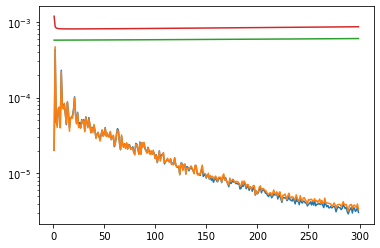

In [13]:
%matplotlib inline
fig,ax=plt.subplots()

ax.plot(cls_ksz['kszr'][:300])
ax.plot(cls_ksz['kszr_lh'][:300])
ax.plot(cls_ksz['N0_K_normed'][:300])
ax.plot(cls_ksz['N0_K_lh_normed'][:300])

ax.set_yscale('log')